In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
matplotlib.style.use('dark_background')
import re
import seaborn as sns
import sys
from datetime import datetime, timedelta
sys.path.append('E:/')
from function import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'PC'
if pc == 'PC':
    basevol='E:/sophia'
else:
    basevol = 'D:/sophia'
    
basepath = basevol + '/shark_data/'
output_folder = basepath + "processed_data/"
npz_directory = basepath + 'data/'
figures_path = basepath + "figures/"
output_folder = basepath + "processed_data/"
npz_directory = basepath + 'data/'
figures_path = basepath + "figures/"

### define some columns lists

In [3]:
midpoints = [('headx', 'heady'),('btipx', 'btipy'), ('pelvicfinx', 'pelvicfiny'), ('sdfinx', 'sdfiny'), ('pedunclex', 'peduncley'), ('finx','finy'), ('ttipx', 'ttipy')]
midpoints_centered = [('centered_headx', 'centered_heady'),('centered_btipx', 'centered_btipy'), ('centered_pelvicfinx', 'centered_pelvicfiny'), ('centered_sdfinx', 'centered_sdfiny'), ('centered_pedunclex', 'centered_peduncley'), ('centered_finx','centered_finy'), ('centered_ttipx', 'centered_ttipy')]
midpoints_rotated = [('rotated_headx', 'rotated_heady'),('rotated_btipx', 'rotated_btipy'), ('rotated_pelvicfinx', 'rotated_pelvicfiny'), ('rotated_sdfinx', 'rotated_sdfiny'), ('rotated_pedunclex', 'rotated_peduncley'), ('rotated_finx','rotated_finy'), ('rotated_ttipx', 'rotated_ttipy')]


In [4]:
file_filters = ["*DJI_0305*","*DJI_0262*","*DJI_0139*"]
sharks_df_tmp = []
for file_filter in file_filters:
    files_list = np.sort(glob.glob(npz_directory + file_filter))
    
    # Check if there are no files
    if len(files_list) == 0:  
        print(f"No files found for {file_filter}")
        continue

    # Get the filename without extension and base filename
    filename_with_extension = os.path.basename(files_list[0])
    filename = os.path.splitext(filename_with_extension)[0]
    base_filename = filename.rsplit('_', 1)[0]
    sharks_df_tmp.append(pd.read_hdf(output_folder  + base_filename + "_sharks.h5", key='sharks'))
sharks_df = pd.concat(sharks_df_tmp,axis=0).reset_index()

### Read shark data

In [5]:
# sharks_df = pd.read_hdf(output_folder  + base_filename + "_sharks.h5", key='sharks')
df_sheets = pd.read_excel(basepath +'Sharkfilesworkingwith.xlsx',sheet_name=[0, 1, 2])

In [6]:
df_carangids=df_sheets[0]
df_drone=df_sheets[1]
dffiltered=df_sheets[2]

In [8]:
# FPS (frames per second)
fps = 50

# Function to convert time string to frames (treating 'hours' as minutes)
def time_to_frames(time_value, fps):
    if pd.isnull(time_value):  # Handle missing values
        return None
    
    try:
        if isinstance(time_value, str):
            # Always treat the first two components as minutes and seconds
            time_obj = datetime.strptime(time_value, "%H:%M:%S")
        else:  # If the input is already a time object
            time_obj = time_value
        
        # Treat 'hours' as minutes, calculate total seconds
        total_seconds = (time_obj.minute * 60) + time_obj.second
        return total_seconds * fps  # Convert total seconds to frames
    
    except Exception as e:
        print(f"Error converting {time_value}: {e}")
        return None  # Handle any errors during conversion

# Function to convert frames to time string (minutes:seconds)
def frames_to_time_string(frames, fps):
    if pd.isnull(frames) or frames is None:  # Handle missing values
        return None
    
    try:
        total_seconds = frames / fps
        hours = int(total_seconds // 3600)
        minutes = int((total_seconds % 3600) // 60)
        seconds = int(total_seconds % 60)
        # Return as a string formatted as "MM:SS"
        return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    
    except Exception as e:
        print(f"Error converting {frames}: {e}")
        return None

# Only convert start_time and end_time to frames if frames are missing
df_carangids['start_frame'] = df_carangids.apply(
    lambda row: row['start_frame'] if not pd.isnull(row['start_frame']) else time_to_frames(row['start_time (video)'], fps),
    axis=1)

df_carangids['end_frame'] = df_carangids.apply(
    lambda row: row['end_frame'] if not pd.isnull(row['end_frame']) else time_to_frames(row['end_time (video)'], fps),
    axis=1)

df_drone['start_frame'] = df_drone.apply(
    lambda row: row['start_frame'] if not pd.isnull(row['start_frame']) else time_to_frames(row['start_time (video)'], fps),
    axis=1)

df_drone['end_frame'] = df_drone.apply(
    lambda row: row['end_frame'] if not pd.isnull(row['end_frame']) else time_to_frames(row['end_time (video)'], fps),
    axis=1)

dffiltered['start_frame'] = dffiltered.apply(
    lambda row: row['start_frame'] if not pd.isnull(row['start_frame']) else time_to_frames(row['start_time (video)'], fps),
    axis=1)

dffiltered['end_frame'] = dffiltered.apply(
    lambda row: row['end_frame'] if not pd.isnull(row['end_frame']) else time_to_frames(row['end_time (video)'], fps),
    axis=1)

# Only convert frames back to time strings if time strings are missing
df_carangids['start_time (video)'] = df_carangids.apply(
    lambda row: row['start_time (video)'] if not pd.isnull(row['start_time (video)']) else frames_to_time_string(row['start_frame'], fps),
    axis=1)

df_carangids['end_time (video)'] = df_carangids.apply(
    lambda row: row['end_time (video)'] if not pd.isnull(row['end_time (video)']) else frames_to_time_string(row['end_frame'], fps),
    axis=1)

df_drone['start_time (video)'] = df_drone.apply(
    lambda row: row['start_time (video)'] if not pd.isnull(row['start_time (video)']) else frames_to_time_string(row['start_frame'], fps),
    axis=1)

df_drone['end_time (video)'] = df_drone.apply(
    lambda row: row['end_time (video)'] if not pd.isnull(row['end_time (video)']) else frames_to_time_string(row['end_frame'], fps),
    axis=1)

dffiltered['start_time (video)'] = dffiltered.apply(
    lambda row: row['start_time (video)'] if not pd.isnull(row['start_time (video)']) else frames_to_time_string(row['start_frame'], fps),
    axis=1)

dffiltered['end_time (video)'] = dffiltered.apply(
    lambda row: row['end_time (video)'] if not pd.isnull(row['end_time (video)']) else frames_to_time_string(row['end_frame'], fps),
    axis=1)

# Display the updated DataFrame with start_frame and end_frame
print(df_carangids[['start_time (video)', 'end_time (video)', 'start_frame', 'end_frame']])
print(df_drone[['start_time (video)', 'end_time (video)', 'start_frame', 'end_frame']])
print(dffiltered[['start_time (video)', 'end_time (video)', 'start_frame', 'end_frame']])


   start_time (video) end_time (video)  start_frame  end_frame
0            00:06:43         00:09:15      20000.0    26000.0
1            00:07:47         00:08:00      23350.0    24000.0
2            00:07:11         00:07:21      21550.0    22050.0
3            00:01:03         00:01:06       3150.0     3300.0
4            00:03:38         00:03:43      10900.0    11150.0
5            00:03:44         00:03:57      11200.0    11850.0
6            00:04:24         00:04:35      13200.0    13750.0
7            00:04:39         00:05:23      13950.0    16150.0
8            00:05:31         00:05:42      16550.0    17100.0
9            00:05:49         00:05:53      17450.0    17650.0
10           00:06:08         00:06:21      18400.0    19050.0
11           00:06:08         00:06:21      18400.0    19050.0
12           00:06:27         00:06:39      19350.0    19950.0
13           00:08:52         00:09:15      26600.0    27750.0
14           00:00:00         00:02:13          0.0    

In [14]:
# Initialize 'carangids' column to 0
sharks_df['carangids'] = 0

# Iterate through each row in df_carangids and apply conditions for each sequence
for _, row in df_carangids.iterrows():
    start, end = row['start_frame'], row['end_frame']
    target_id = row['sharkID_carangids']  # The specific ID from df_carangids
    sequence_name = row['sequence_name']  # The specific sequence from df_carangids

    # Update the mask: Check frame range, ID match, and sequence name
    mask = (
        (sharks_df['frame'] >= start) & 
        (sharks_df['frame'] <= end) & 
        (sharks_df['ID'] == target_id) &
        (sharks_df['Trial'] == sequence_name)  # Ensure matching sequence
    )

    # Apply 'carangids' = 1 where the mask is True
    sharks_df.loc[mask, 'carangids'] = 1

# Display the updated DataFrame
print(sharks_df[['frame', 'ID', 'carangids', 'Trial']])


        frame  ID  carangids                                 Trial
0           0   0          1  sequence_20240305_164039273_DJI_0305
1           1   0          1  sequence_20240305_164039273_DJI_0305
2           2   0          1  sequence_20240305_164039273_DJI_0305
3           3   0          1  sequence_20240305_164039273_DJI_0305
4           4   0          1  sequence_20240305_164039273_DJI_0305
...       ...  ..        ...                                   ...
414475  85938   1          0  sequence_20240306_161443984_DJI_0139
414476  85939   1          0  sequence_20240306_161443984_DJI_0139
414477  85940   1          0  sequence_20240306_161443984_DJI_0139
414478  85941   1          0  sequence_20240306_161443984_DJI_0139
414479  85942   1          0  sequence_20240306_161443984_DJI_0139

[414480 rows x 4 columns]


In [12]:
# Add empty columns to sharks_df for the new data
sharks_df['drone_movement'] = 0
sharks_df['ID_checked'] = 0

# Iterate over each row in df_drone to apply values to sharks_df
for _, drone_row in df_drone.iterrows():
    # Get the sequence name and frame range from df_drone
    sequence = drone_row['sequence_name']
    start_frame = drone_row['start_frame']
    end_frame = drone_row['end_frame']
    drone_movement = drone_row['drone movement [0,1]']
    id_checked = drone_row['IDs checked [0,1]']
    
    # Update matching frames in sharks_df for the same trail and frame range
    mask = (
        (sharks_df['Trial'] == sequence) &
        (sharks_df['frame'] >= start_frame) &
        (sharks_df['frame'] <= end_frame)
    )
    
    # Assign the drone movement and ID checked values to the matching rows
    sharks_df.loc[mask, 'drone_movement'] = drone_movement
    sharks_df.loc[mask, 'ID_checked'] = id_checked

# Check the updated sharks_df
print(sharks_df.head())

   index  SPEED#wcentroid  ID     ANGLE  frame  time        headx  \
0      0         0.000000   0 -1.374092      0  0.00  3158.000000   
1      1        35.346706   0 -1.395150      1  0.01  3158.000000   
2      2        73.434263   0 -1.412314      2  0.02  3158.333333   
3      3        83.100634   0 -1.423655      3  0.03  3158.500000   
4      4        76.387733   0 -1.424883      4  0.04  3159.200000   

         heady       lxfinx       lxfiny  ...     finy   ttipx        ttipy  \
0  1441.000000  3137.000000  1462.000000  ...  1517.00  3115.0  1524.000000   
1  1440.000000  3137.500000  1462.000000  ...  1517.00  3115.5  1524.000000   
2  1438.666667  3137.666667  1461.333333  ...  1517.00  3117.0  1524.333333   
3  1437.500000  3138.000000  1460.500000  ...  1516.75  3118.0  1524.250000   
4  1436.800000  3138.600000  1460.000000  ...  1516.60  3118.6  1524.200000   

           X          Y  segment                                 Trial  \
0 -68.715576  89.599609        1  se

In [25]:
for _, filter_row in dffiltered.iterrows():
    # Extract relevant information from df_filtered
    sequence_name = filter_row['sequence_name']
    start_frame = filter_row['start_frame']
    end_frame = filter_row['end_frame']
    id_checked = filter_row['IDs checked [0,1]']
    id_value = filter_row['ID']
    
    # Create a mask to match sharks_df with conditions
    mask = (
        (sharks_df['Trial'] == sequence_name) &   # Match sequence_name (trail)
        (sharks_df['frame'] >= start_frame) &      # Frame is within the range
        (sharks_df['frame'] <= end_frame) &        # Frame is within the range
        (sharks_df['ID'] == id_value)              # Match the ID
    )
    
    # Modify the 'ID_checked' column in sharks_df for the matching rows
    sharks_df.loc[mask, 'ID_checked'] = id_checked

# Display the updated sharks_df to check the results
print(print(sharks_df[['frame', 'ID', 'ID_checked', 'Trial']]))

        frame  ID  ID_checked                                 Trial
0           0   0           1  sequence_20240305_164039273_DJI_0305
1           1   0           1  sequence_20240305_164039273_DJI_0305
2           2   0           1  sequence_20240305_164039273_DJI_0305
3           3   0           1  sequence_20240305_164039273_DJI_0305
4           4   0           1  sequence_20240305_164039273_DJI_0305
...       ...  ..         ...                                   ...
414475  85938   1           0  sequence_20240306_161443984_DJI_0139
414476  85939   1           0  sequence_20240306_161443984_DJI_0139
414477  85940   1           0  sequence_20240306_161443984_DJI_0139
414478  85941   1           0  sequence_20240306_161443984_DJI_0139
414479  85942   1           0  sequence_20240306_161443984_DJI_0139

[414480 rows x 4 columns]
None


### Plot random trajectories

In [26]:
sharks_df.head()

,index,SPEED#wcentroid,ID,ANGLE,frame,time,headx,heady,lxfinx,lxfiny,...,finy,ttipx,ttipy,X,Y,segment,Trial,carangids,drone_movement,ID_checked
0,0,0.000000,0,-1.374092,0,0.00,3158.000000,1441.000000,3137.000000,1462.000000,...,1517.00,3115.0,1524.000000,-68.715576,89.599609,1,sequence_20240305_164039273_DJI_0305,1,0,1
1,1,35.346706,0,-1.395150,1,0.01,3158.000000,1440.000000,3137.500000,1462.000000,...,1517.00,3115.5,1524.000000,-67.928223,89.411316,1,sequence_20240305_164039273_DJI_0305,1,0,1
2,2,73.434263,0,-1.412314,2,0.02,3158.333333,1438.666667,3137.666667,1461.333333,...,1517.00,3117.0,1524.333333,-66.910238,88.499634,1,sequence_20240305_164039273_DJI_0305,1,0,1
3,3,83.100634,0,-1.423655,3,0.03,3158.500000,1437.500000,3138.000000,1460.500000,...,1516.75,3118.0,1524.250000,-66.271301,87.701447,1,sequence_20240305_164039273_DJI_0305,1,0,1
4,4,76.387733,0,-1.424883,4,0.04,3159.200000,1436.800000,3138.600000,1460.000000,...,1516.60,3118.6,1524.200000,-65.608643,87.355884,1,sequence_20240305_164039273_DJI_0305,1,0,1


In [30]:
sharks_df_filtered = sharks_df[(sharks_df['ID_checked'] == 1) & (sharks_df['drone_movement'] == 0)]

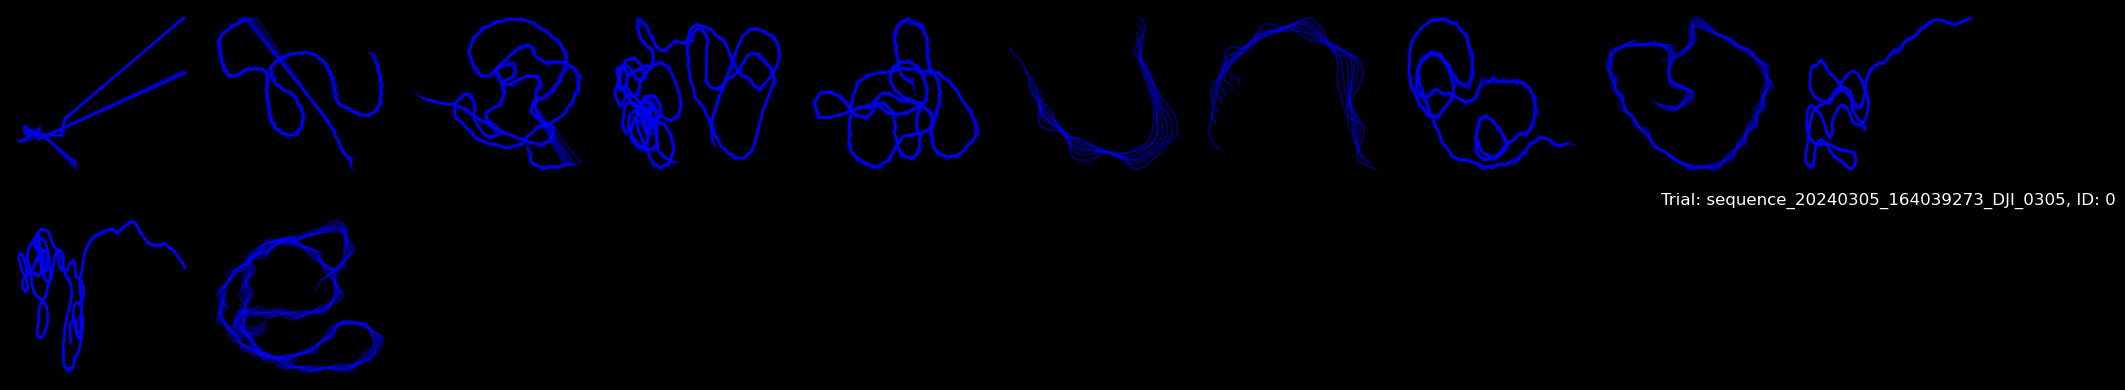

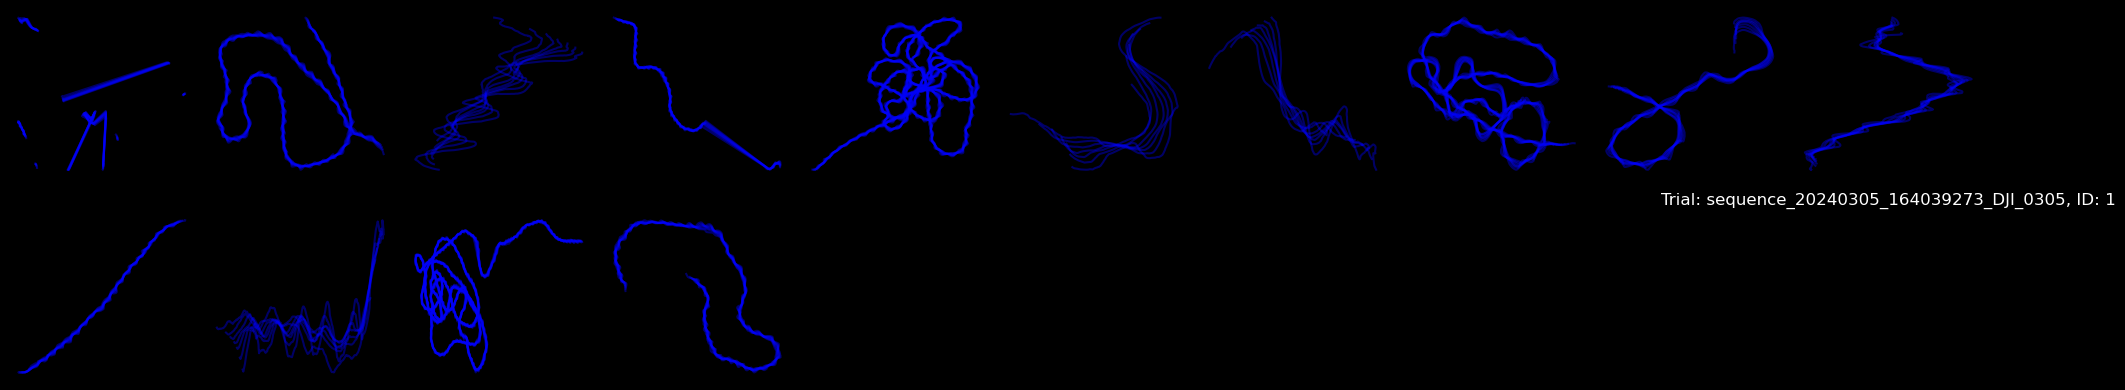

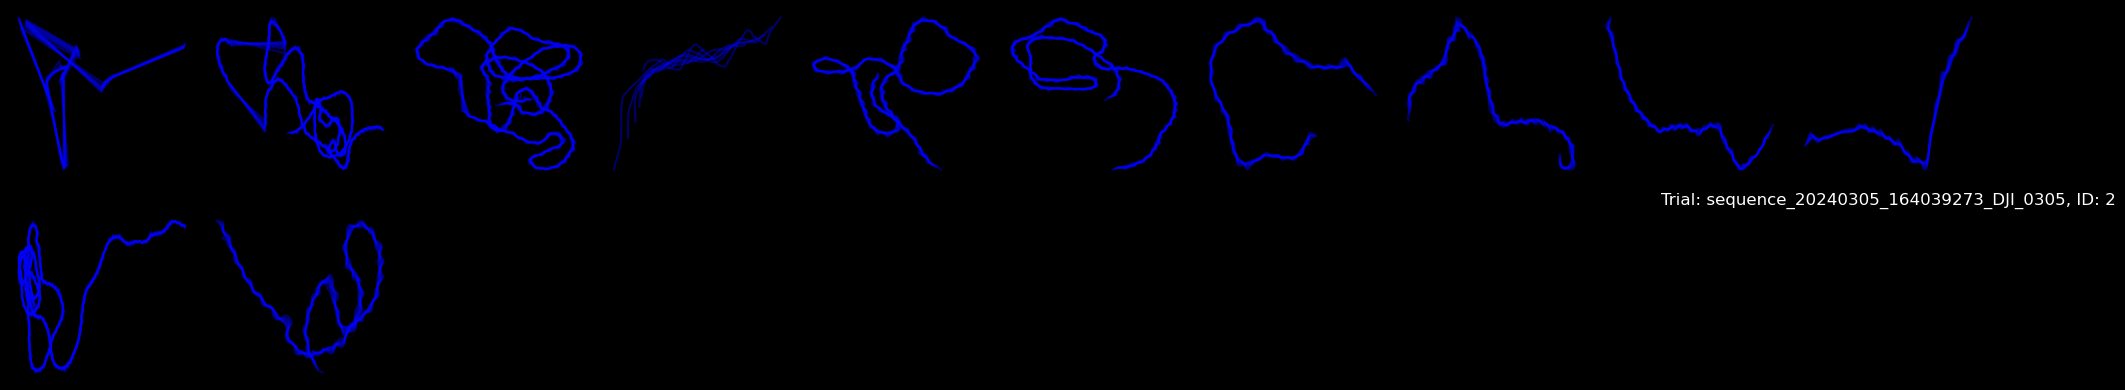

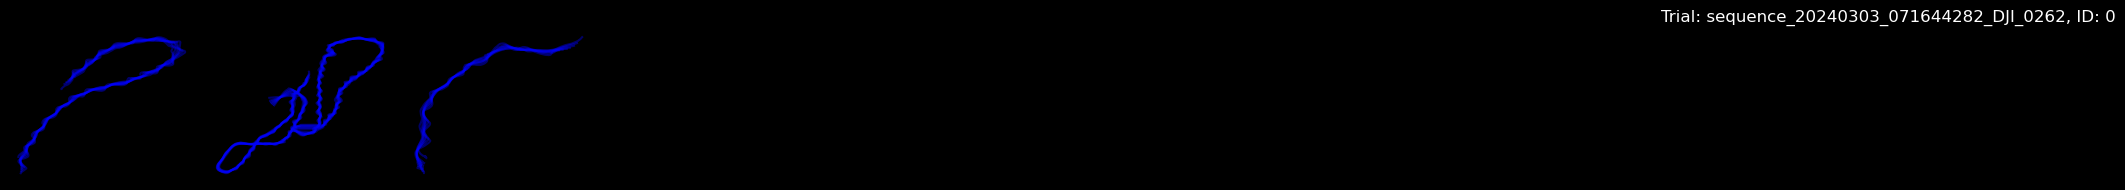

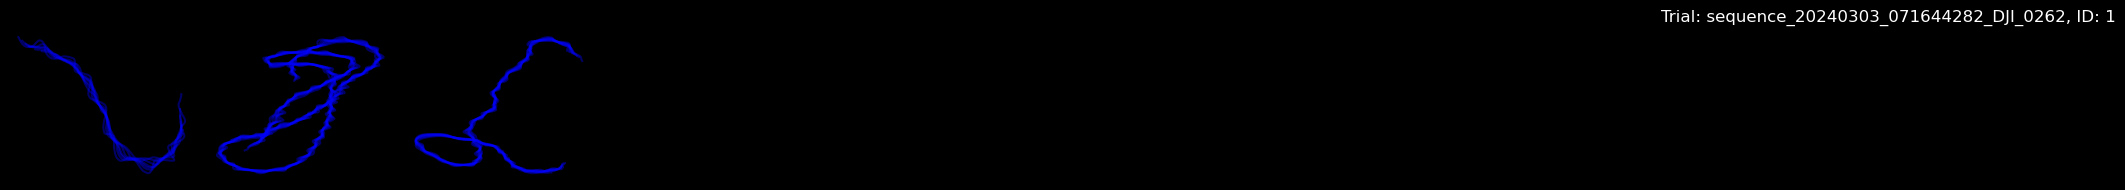

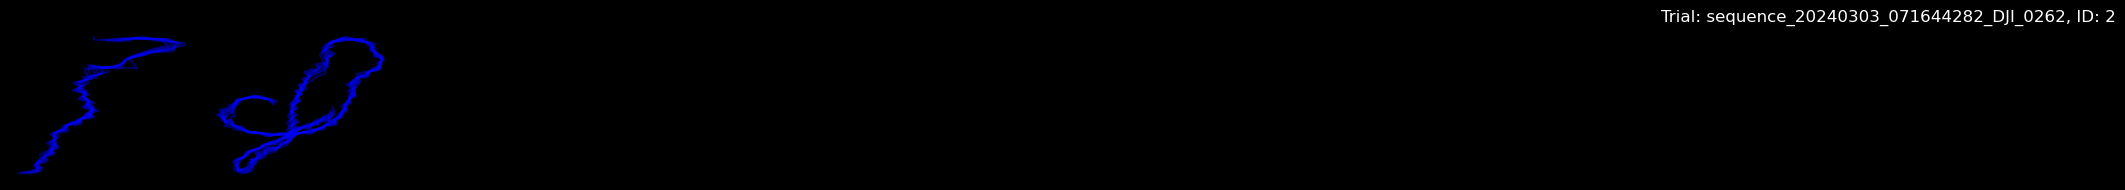

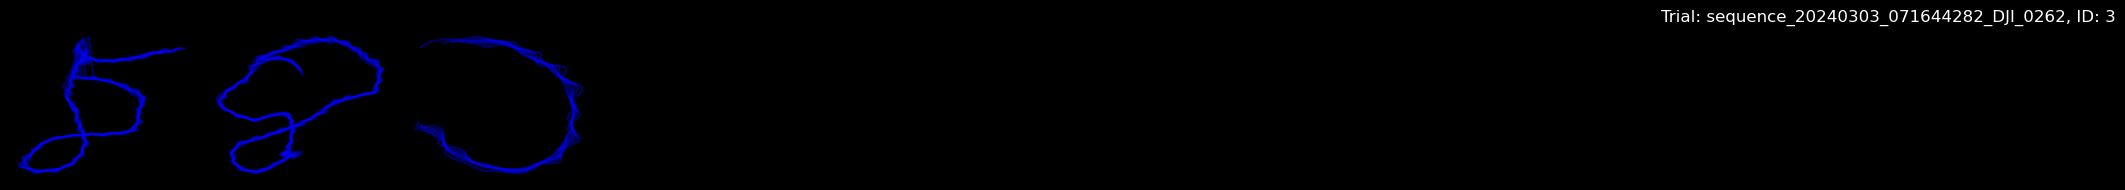

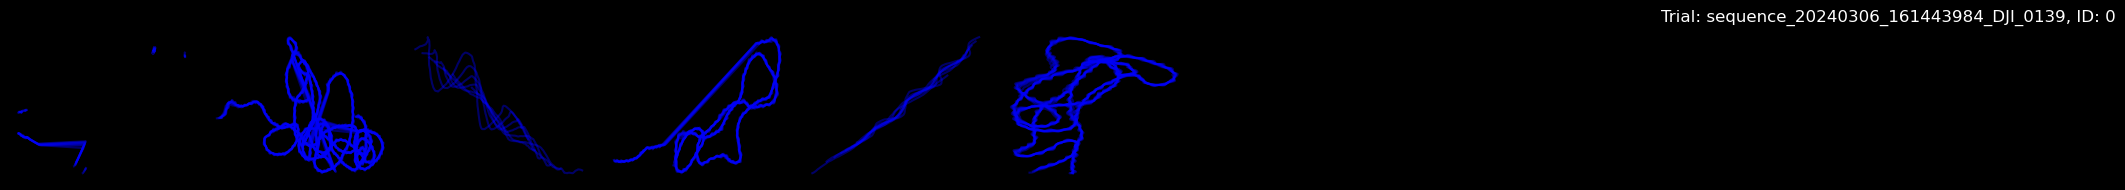

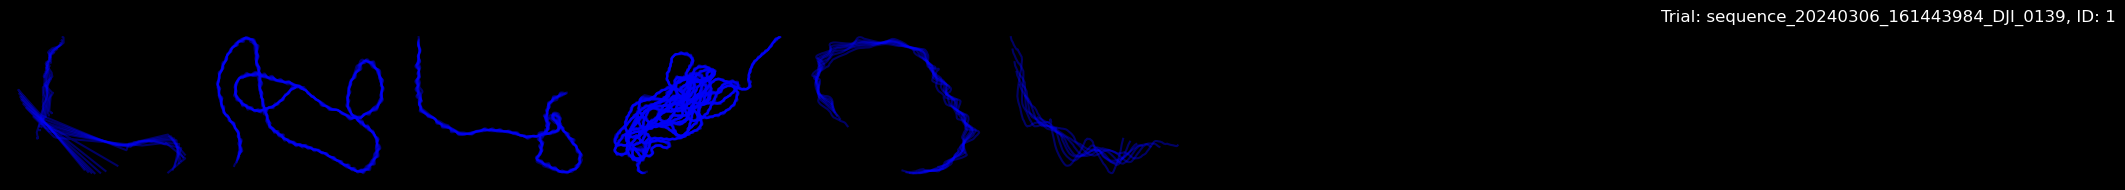

In [31]:
# Get all unique IDs in the dataset
#unique_sequence = sharks_df['Trial'].unique()

for trial in sharks_df_filtered.Trial.unique():
    onetrial = sharks_df_filtered[sharks_df_filtered['Trial'] == trial]
    unique_ids = onetrial['ID'].unique()
    for current_id in unique_ids:
        # Filter data for the current ID
        onef = onetrial[onetrial['ID'] == current_id]
        
        # Filter segments that have more than 100 frames
        segment_counts = onef['segment'].value_counts()
        segments_to_plot = np.sort(segment_counts[segment_counts > 100].index)
    
        # If no segments have more than 100 frames, skip this ID
        if len(segments_to_plot) == 0:
            continue
    
        # Define the number of subplots (adjust rows and columns based on the number of valid segments)
        num_segments = len(segments_to_plot)
        num_rows = (num_segments // 10) + 1
        fig, axes = plt.subplots(num_rows, 10, figsize=(20, num_rows * 2))
        
        # Flatten axes to easily iterate
        axes = axes.flatten()
    
        # Loop through the valid segments and plot in subplots
        for idx, (ax, segment) in enumerate(zip(axes, segments_to_plot)):
            # Filter data for the current segment
            short = onef[onef['segment'] == segment]
            
            # Loop through midpoints (assuming it is defined as pairs of x_col and y_col)
            for i, (x_col, y_col) in enumerate(midpoints):
                ax.plot(short[x_col], short[y_col], color="blue", alpha=0.4)
                

            # Optionally set a title with the segment information
            
            ax.axis('off')
    
        # Hide any unused subplots if necessary
        for ax in axes[len(segments_to_plot):]:
            ax.axis('off')
        ax.set_title(f"Trial: {trial}, ID: {current_id}")
        # Adjust the layout and show the plot for the current ID
        plt.tight_layout()
        plt.show()


### Check n of frames in each segment and each shark ID


In [37]:
sharks_df_filtered.groupby(['ID','Trial']).count()

index  SPEED#wcentroid  ANGLE  frame  \
ID Trial                                                                        
0  sequence_20240303_071644282_DJI_0262   5150             5123   5123   5150   
   sequence_20240305_164039273_DJI_0305  44504            43487  43487  44504   
   sequence_20240306_161443984_DJI_0139  38393            36035      0  38393   
1  sequence_20240303_071644282_DJI_0262   5651             5585   5585   5651   
   sequence_20240305_164039273_DJI_0305  44504            35613  35613  44504   
   sequence_20240306_161443984_DJI_0139  51369            37972      0  51369   
2  sequence_20240303_071644282_DJI_0262   4507             4443   4443   4507   
   sequence_20240305_164039273_DJI_0305  44504            38807  38807  44504   
3  sequence_20240303_071644282_DJI_0262   5651             5629   5629   5651   

                                          time  headx  heady  lxfinx  lxfiny  \
ID Trial                                                                       
0  sequence_20240303_071644282_DJI_0262   5150   5123   5123    5123    5123   
   sequence_20240305_164039273_DJI_0305  44504  43487  43487   43487   43487   
   sequence_20240306_161443984_DJI_0139  38393  36035  36035   36035   36035   
1  sequence_20240303_071644282_DJI_0262   5651   5585   5585    5585    5585   
   sequence_20240305_164039273_DJI_0305  44504  35613  35613   35613   35613   
   sequence_20240306_161443984_DJI_0139  51369  37972  37972   37972   37972   
2  sequence_20240303_071644282_DJI_0262   4507   4443   4443    4443    4443   
   sequence_20240305_164039273_DJI_0305  44504  38807  38807   38807   38807   
3  sequence_20240303_071644282_DJI_0262   5651   5629   5629    5629    5629   

                                         btipx  ...   finx   finy  ttipx  \
ID Trial                                        ...                        
0  sequence_20240303_071644282_DJI_0262   5123  ...   5123   5123   5123   
   sequence_20240305_164039273_DJI_0305  43487  ...  43487  43487  43487   
   sequence_20240306_161443984_DJI_0139  36035  ...  36035  36035  36035   
1  sequence_20240303_071644282_DJI_0262   5585  ...   5585   5585   5585   
   sequence_20240305_164039273_DJI_0305  35613  ...  35612  35612  35612   
   sequence_20240306_161443984_DJI_0139  37972  ...  37972  37972  37972   
2  sequence_20240303_071644282_DJI_0262   4443  ...   4443   4443   4443   
   sequence_20240305_164039273_DJI_0305  38807  ...  38807  38807  38807   
3  sequence_20240303_071644282_DJI_0262   5629  ...   5629   5629   5629   

                                         ttipy      X      Y  segment  \
ID Trial                                                                
0  sequence_20240303_071644282_DJI_0262   5123   5123   5123     5150   
   sequence_20240305_164039273_DJI_0305  43487  43487  43487    44504   
   sequence_20240306_161443984_DJI_0139  36035      0      0    38393   
1  sequence_20240303_071644282_DJI_0262   5585   5585   5585     5651   
   sequence_20240305_164039273_DJI_0305  35612  35613  35613    44504   
   sequence_20240306_161443984_DJI_0139  37972      0      0    51369   
2  sequence_20240303_071644282_DJI_0262   4443   4443   4443     4507   
   sequence_20240305_164039273_DJI_0305  38807  38807  38807    44504   
3  sequence_20240303_071644282_DJI_0262   5629   5629   5629     5651   

                                         carangids  drone_movement  ID_checked  
ID Trial                                                                        
0  sequence_20240303_071644282_DJI_0262       5150            5150        5150  
   sequence_20240305_164039273_DJI_0305      44504           44504       44504  
   sequence_20240306_161443984_DJI_0139      38393           38393       38393  
1  sequence_20240303_071644282_DJI_0262       5651            5651        5651  
   sequence_20240305_164039273_DJI_0305      44504           44504       44504  
   sequence_20240306_161443984_DJI_0139      51369          

### Now calculate pairwise distance and NN distance 

In [14]:
subset = sharks_df[sharks_df['Trial']==('sequence_20240305_164039273_DJI_0305')][['ID', 'frame', 'X', 'Y','carangids','Trial']]

In [15]:
### Example to calculate pw distance

fishlist = np.unique(subset["ID"].values)
maxframe = len(np.unique(subset["frame"].values))
num_individuals = len(np.unique(subset["ID"].values))
pairwise_df = np.zeros((num_individuals, num_individuals, maxframe))
sel_fish = subset.groupby("ID")

#     df_pairwise = []
for ixff, fish in enumerate(fishlist):

    ff_ = sel_fish.get_group(fish)
    x_ff_ = ff_["X"].values
    x_ff_ = np.asarray(list(x_ff_))

    y_ff_ = ff_["Y"].values
    y_ff_ = np.asarray(list(y_ff_))

    for ixnf, nf in enumerate(fishlist):  # list_no_fish:

        nf_ = sel_fish.get_group(nf)
        x_nf_ = nf_["X"].values
        x_nf_ = np.asarray(list(x_nf_))

        y_nf_ = nf_["Y"].values
        y_nf_ = np.asarray(list(y_nf_))
        pairwise_df[ixff, ixnf, :] = pairwise_distance(x_ff_, y_ff_, x_nf_, y_nf_,num_individuals)
    

In [32]:
pairwise_df.shape # nind x nind x frames

(3, 3, 47488)

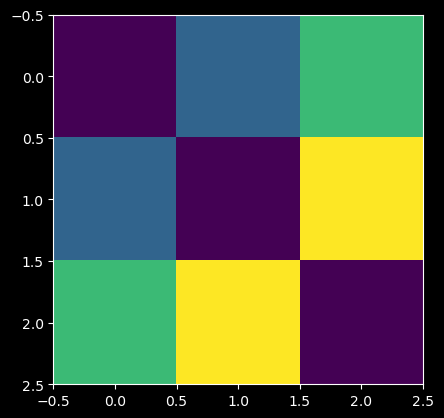

In [16]:
### Plot ONE frame of pw distance of all IDs in that frame
plt.imshow(pairwise_df[:,:,10])

In [36]:
pairwise_df[:,:,0]

array([[          nan,  407.84385835,  881.88583036],
       [ 407.84385835,           nan, 1289.09668373],
       [ 881.88583036, 1289.09668373,           nan]])

In [34]:
mindist[0]

array([407.84385835, 407.84385835, 881.88583036])

In [17]:
#### NN distance
lst = np.arange(num_individuals)

distinf = pairwise_df.T

distinf[:, lst, lst] = np.nan

# Replace rows where all values are NaN with np.inf to avoid issues
all_nan_mask = np.all(np.isnan(distinf), axis=1)
distinf[all_nan_mask] = np.inf

# Compute the nearest neighbor distances, ignoring NaNs
mindist = np.nanmin(distinf, axis=1)

# Optional: Replace np.inf with NaN if you want to indicate no neighbors were found
#mindist[np.isinf(mindist)] = np.nan

# Now, mindist should hold the nearest neighbor distances for each individual
print(mindist)


[[ 407.84385835  407.84385835  881.88583036]
 [ 408.84513235  408.84513235  879.75399942]
 [ 410.59830375  410.59830375  876.92007493]
 ...
 [ 450.9224942  1162.3656081   450.9224942 ]
 [ 451.43077009 1160.95121276  451.43077009]
 [ 451.9682525  1159.76409567  451.9682525 ]]


### Add nn distance to the dataframe

In [43]:
mindist[:,0]

array([407.84385835, 408.84513235, 410.59830375, ..., 450.9224942 ,
       451.43077009, 451.9682525 ])

In [48]:
for idshark in range(num_individuals):
    subset.loc[subset['ID']==idshark,'nndist'] = mindist[:,idshark]


<Axes: xlabel='ID', ylabel='nndist'>

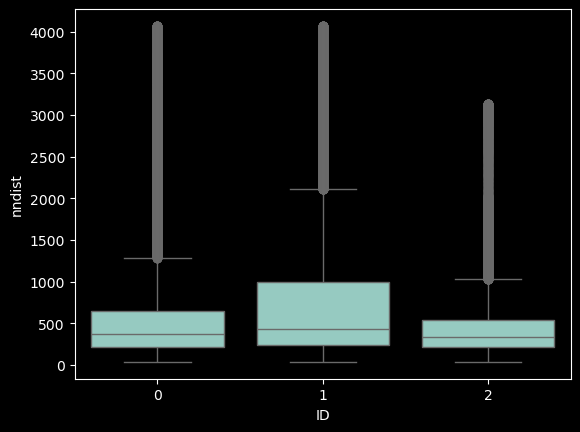

In [50]:
sns.boxplot(x='ID',y='nndist',data = subset)

<Axes: xlabel='frame', ylabel='nndist'>

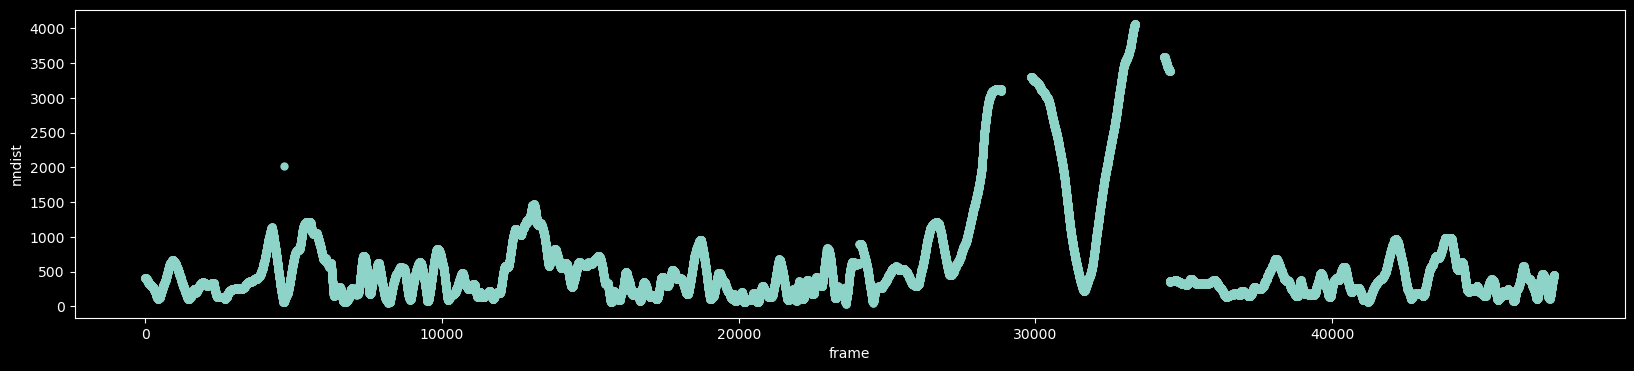

In [54]:
plt.subplots(1,1,figsize=(20,4))
sns.scatterplot(x='frame',y='nndist',data = subset[subset['ID']==0],linewidth=0)

#### CHECK frame order for pw distances and add NN ID to the dataframe

In [44]:
subset.frame.unique()

array([    0,     1,     2, ..., 47485, 47486, 47487])

In [30]:
mindist.shape

(47488, 3)

In [29]:
nearest_neighbor_distances

array([[ 407.84385835,  408.84513235,  410.59830375, ...,  450.9224942 ,
         451.43077009,  451.9682525 ],
       [ 407.84385835,  408.84513235,  410.59830375, ..., 1162.3656081 ,
        1160.95121276, 1159.76409567],
       [ 881.88583036,  879.75399942,  876.92007493, ...,  450.9224942 ,
         451.43077009,  451.9682525 ]])

In [18]:
subset.groupby(['ID']).count()

,frame,X,Y,carangids,Trial
ID,,,,,
0,47488,46471,46471,47488,47488
1,47488,38177,38177,47488,47488
2,47488,41791,41791,47488,47488


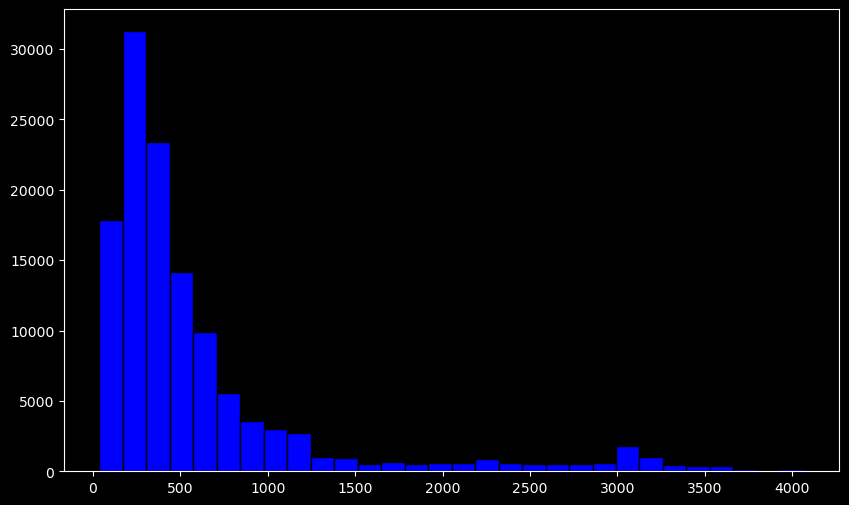

In [20]:
# Filter out any infinite or NaN values from mindist
filtered_mindist = mindist[np.isfinite(mindist)]

# Create a histogram for the filtered nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(filtered_mindist, bins=30, color='blue', edgecolor='black')
plt.show()


In [21]:
# Initialize nearest_neighbors array with a placeholder value (e.g., -1)
nearest_neighbors = np.full((pairwise_df.shape[0], pairwise_df.shape[2]), -1, dtype=int)  # Shape: (4, 967)

# Loop through each frame set
for i in range(pairwise_df.shape[2]):
    # Set diagonal to np.nan to ignore distances to self
    temp_matrix = pairwise_df[:, :, i].copy()
    np.fill_diagonal(temp_matrix, np.nan)
    
    # Check if there are non-NaN values in the row
    valid_mask = ~np.all(np.isnan(temp_matrix), axis=1)
    
    # Find the index of the nearest neighbor for each frame in this specific set (only for valid rows)
    if np.any(valid_mask):
        nearest_neighbors[valid_mask, i] = np.nanargmin(temp_matrix[valid_mask], axis=1)

# Display the nearest neighbors
print(nearest_neighbors)


[[1 1 1 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 0 0 0]]


<Axes: >

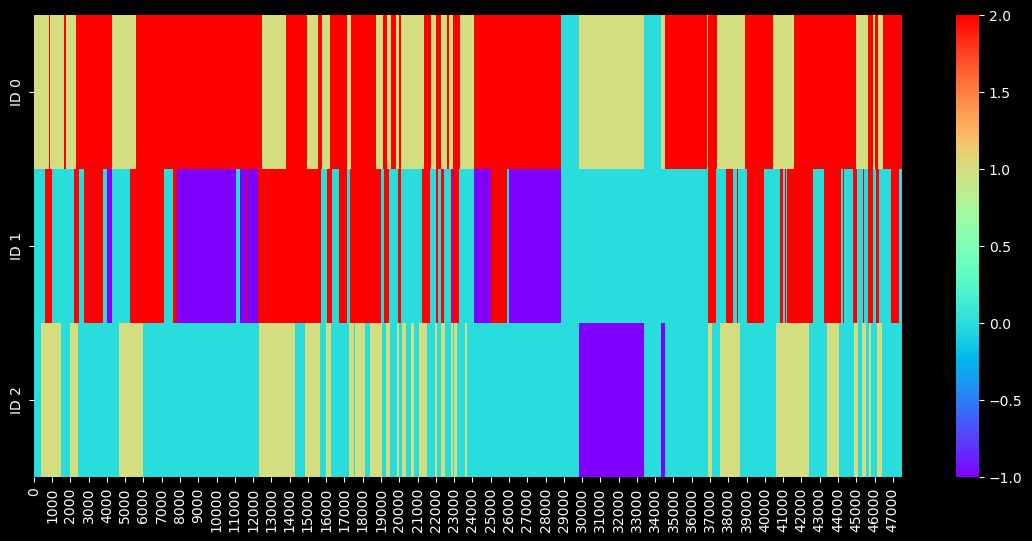

In [22]:
#Heatmap of Nearest 
plt.figure(figsize=(14, 6))
sns.heatmap(nearest_neighbors, cmap='rainbow', cbar=True, 
            xticklabels=1000, yticklabels=[f'ID {i}' for i in range(nearest_neighbors.shape[0])])

<Axes: xlabel='X', ylabel='Y'>

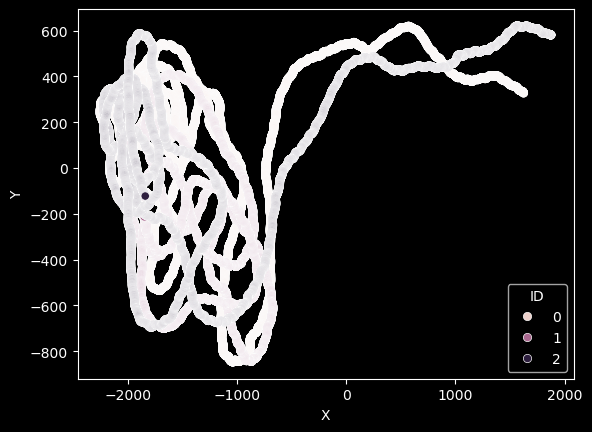

In [25]:
sns.scatterplot(x= 'X', y = 'Y', hue = 'ID', data = sharks_df[sharks_df['frame'].between(34530, 43633)])

### Tasks:
- NN distance at each frame
- column with n sharks in each frame 
- select a range within which you know the shark that has the carangids: compare its NN distance
- plot other kinematics of that shark with and without carangids (e.g. speed, acceleration, angular velocity, nn distance)

### n Sharks in frame

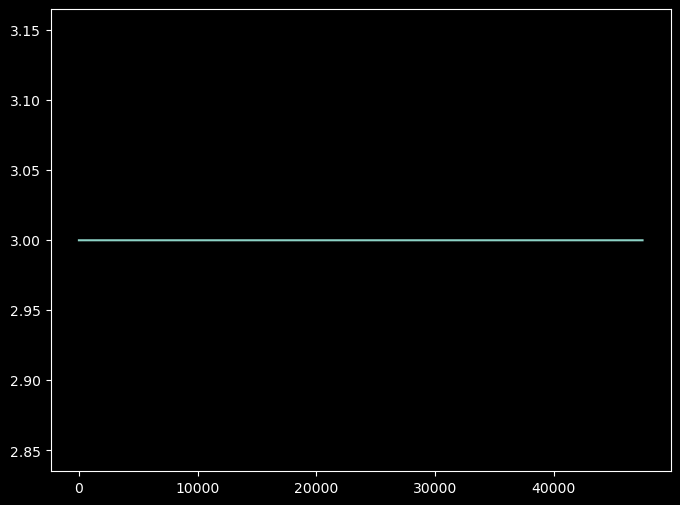

In [26]:
# Count the total number of IDs (not necessarily unique) for each frame
id_count_per_frame = sharks_df[sharks_df["Trial"] == 'sequence_20240305_164039273_DJI_0305'].groupby("frame")["ID"].count()

plt.figure(figsize=(8, 6))
plt.plot(id_count_per_frame)


## NN with and without Carangids

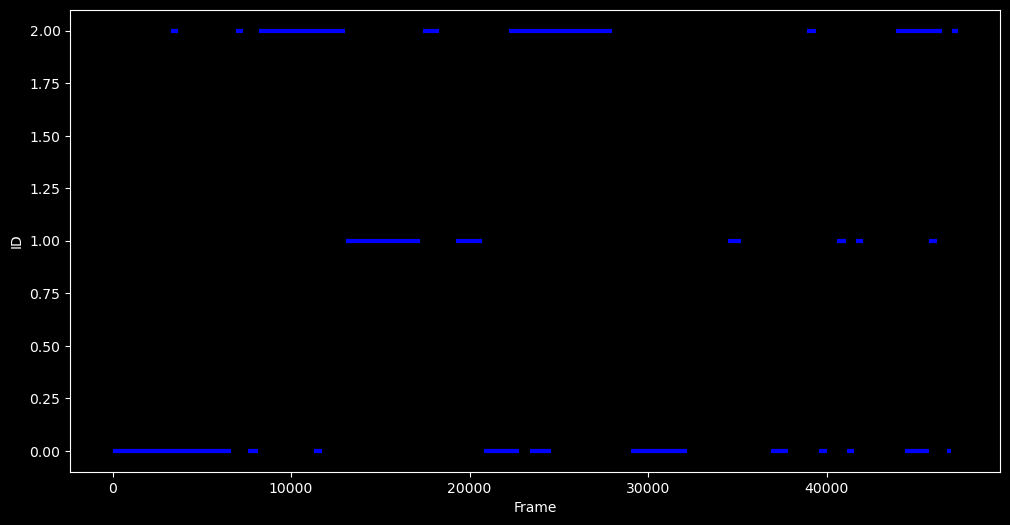

In [27]:
# Create the plot
plt.figure(figsize=(12, 6))
df_sheets_select=df_carangids.loc[df_carangids['sequence_name']== 'sequence_20240305_164039273_DJI_0305']
# Plot horizontal lines showing the time duration for each segment of each ID
for _, row in df_sheets_select.iterrows():
    plt.hlines(y=row['sharkID_carangids'], xmin=row['start_frame'], xmax=row['end_frame'], color='blue', linewidth=3)

# Labeling and aesthetics
plt.xlabel('Frame')
plt.ylabel('ID')
plt.show()


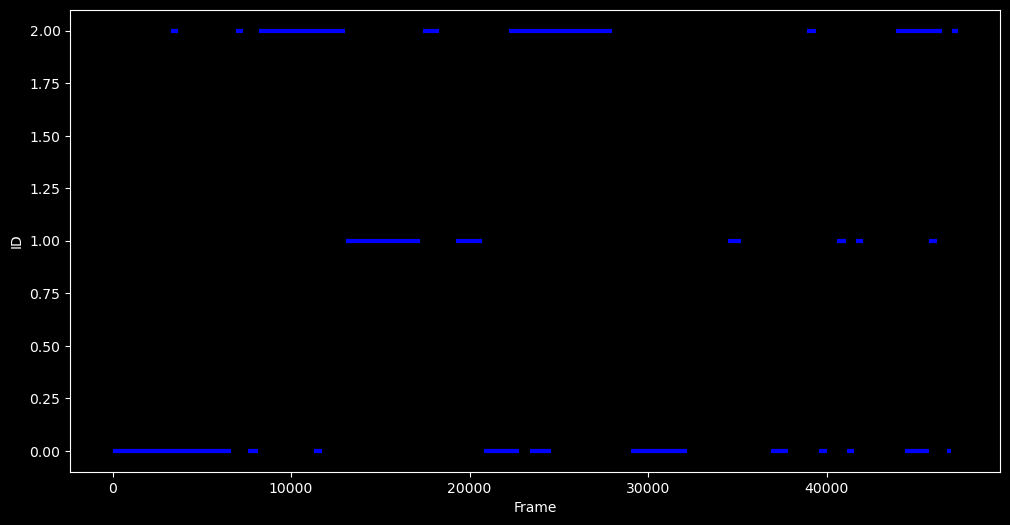

In [28]:
# Filter the data to include only frames where carangids = 1
subset_carangids_1 = subset[subset['carangids'] == 1]

# Identify periods where each ID maintains carangids = 1
id_ranges = []
current_id = None
current_start = None

# Iterate through the DataFrame, grouped by ID, to detect separate periods of carangids = 1
for id_, group in subset_carangids_1.groupby('ID'):
    # Sort by frame to ensure continuous detection
    group = group.sort_values('frame')
    current_start = group['frame'].iloc[0]
    
    # Track the end of each contiguous sequence
    for i in range(1, len(group)):
        if group['frame'].iloc[i] != group['frame'].iloc[i - 1] + 1:
            # If the current frame is not a continuation, log the previous segment
            id_ranges.append((id_, current_start, group['frame'].iloc[i - 1]))
            current_start = group['frame'].iloc[i]
    
    # Log the last segment for this ID
    id_ranges.append((id_, current_start, group['frame'].iloc[-1]))

# Convert to DataFrame
id_ranges_df = pd.DataFrame(id_ranges, columns=['ID', 'range_start', 'range_end'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot horizontal lines showing the time duration for each segment of each ID
for _, row in id_ranges_df.iterrows():
    plt.hlines(y=row['ID'], xmin=row['range_start'], xmax=row['range_end'], color='blue', linewidth=3)

# Labeling and aesthetics
plt.xlabel('Frame')
plt.ylabel('ID')
plt.show()


In [29]:
nearest_neighbor_distances.shape

(3, 47488)

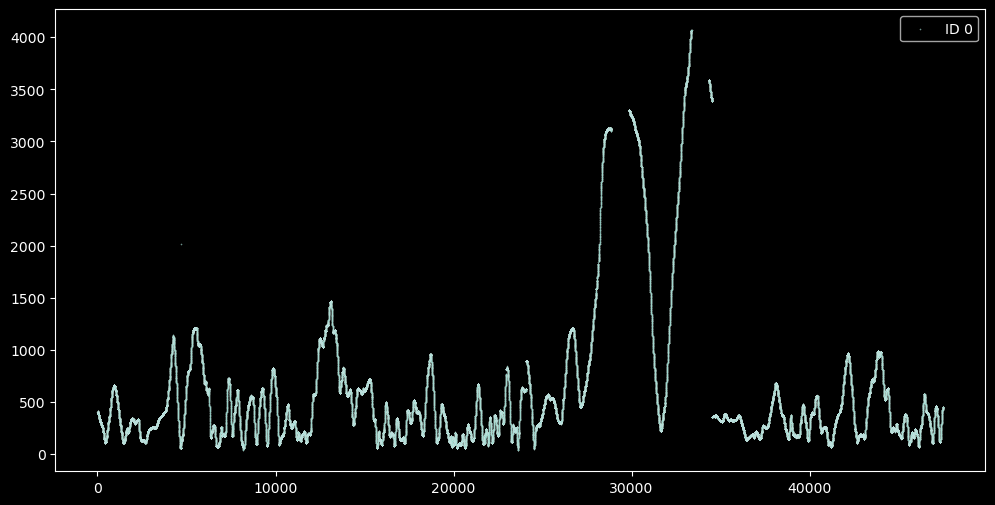

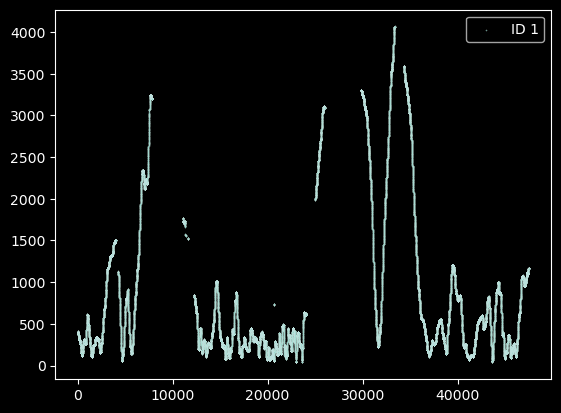

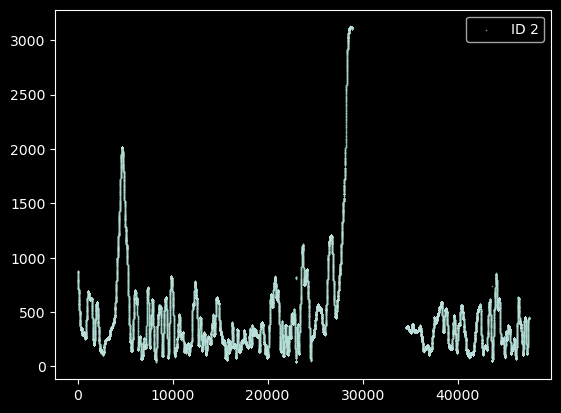

In [30]:
plt.figure(figsize=(12, 6))

# Determine the maximum frame count based on nearest_neighbor_distances
max_frames = nearest_neighbor_distances.shape[1]  # Get the number of frames for the data

for i in range(3):  # Loop through the first three IDs
    # Plot the scatter plot for the nearest neighbor distances for each ID
    sns.scatterplot(x=range(max_frames), y=nearest_neighbor_distances[i, :max_frames], label=f'ID {i}', s=1, alpha=0.7)
    plt.show()

ID 0 distances:
   frame  ID                          nearest_neighbor_distance
0      0   0  [407.84385835190386, 408.845132351628, 410.598...
1      1   0  [407.84385835190386, 408.845132351628, 410.598...
2      2   0  [881.8858303607786, 879.7539994201207, 876.920...



C:\Users\sophi\AppData\Local\Temp\ipykernel_13828\419592131.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


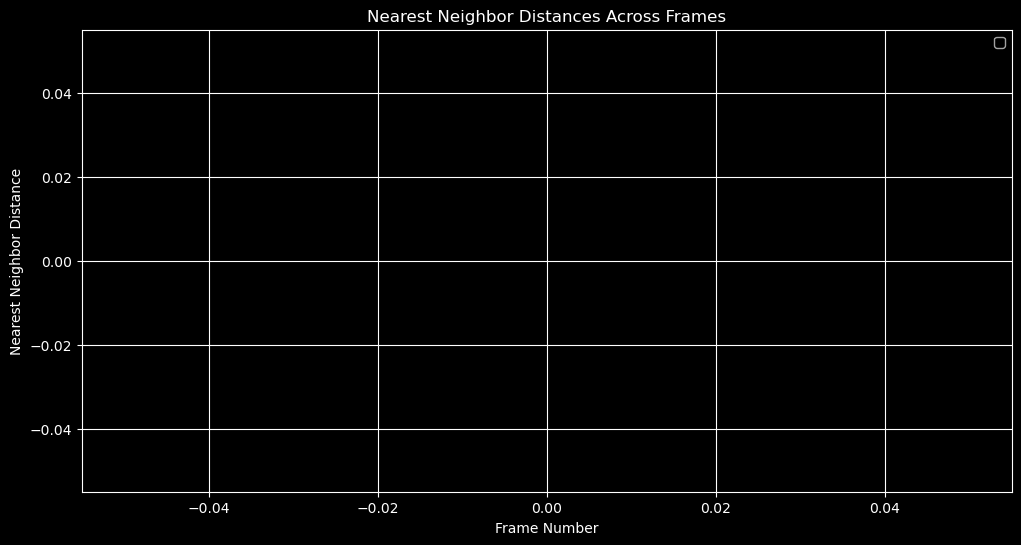

In [31]:
# Initialize a DataFrame to hold frame, ID, and corresponding nearest neighbor distances
distance_mapping = []

# Loop through each row in sharks_df
for idx, row in sharks_df.iterrows():
    frame_number = row['frame']
    shark_id = row['ID']
    
    # Ensure that we have a distance for the current index
    if idx < len(nearest_neighbor_distances):
        distance = nearest_neighbor_distances[idx]
        # Append the frame, ID, and distance to the mapping list
        distance_mapping.append((frame_number, shark_id, distance))

# Convert the distance mapping to a DataFrame for plotting
distance_df = pd.DataFrame(distance_mapping, columns=['frame', 'ID', 'nearest_neighbor_distance'])

# Now we can plot the data
plt.figure(figsize=(12, 6))

# Loop through each unique ID to plot their distances
unique_ids = distance_df['ID'].unique()

for shark_id in unique_ids:
    # Get the distances for the current ID
    id_distances = distance_df[distance_df['ID'] == shark_id]
    
    # Check if id_distances is empty
    if id_distances.empty:
        print(f"No data for ID {shark_id}. Skipping...")
        continue  # Skip this ID if there's no data

    # Debugging: Print the contents of id_distances
    print(f"ID {shark_id} distances:\n{id_distances}\n")
    
    # Ensure that frame and distance columns are numeric
    id_distances['frame'] = pd.to_numeric(id_distances['frame'], errors='coerce')
    id_distances['nearest_neighbor_distance'] = pd.to_numeric(id_distances['nearest_neighbor_distance'], errors='coerce')
    
    # Plot the scatter plot for the current ID
    sns.scatterplot(x=id_distances['frame'], y=id_distances['nearest_neighbor_distance'], label=f'ID {shark_id}', s=1, alpha=0.7)

plt.xlabel('Frame Number')
plt.ylabel('Nearest Neighbor Distance')
plt.title('Nearest Neighbor Distances Across Frames')
plt.grid(True)
plt.legend()
plt.show()

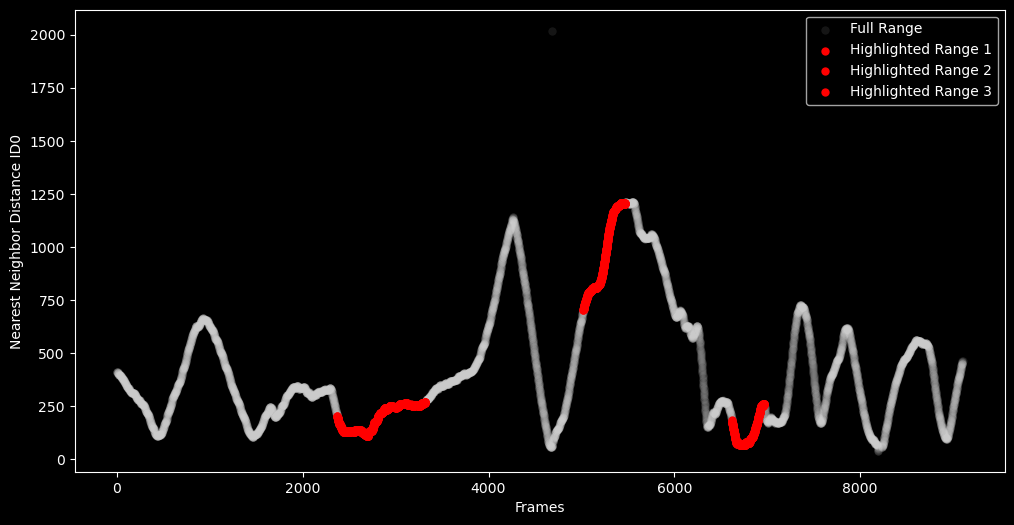

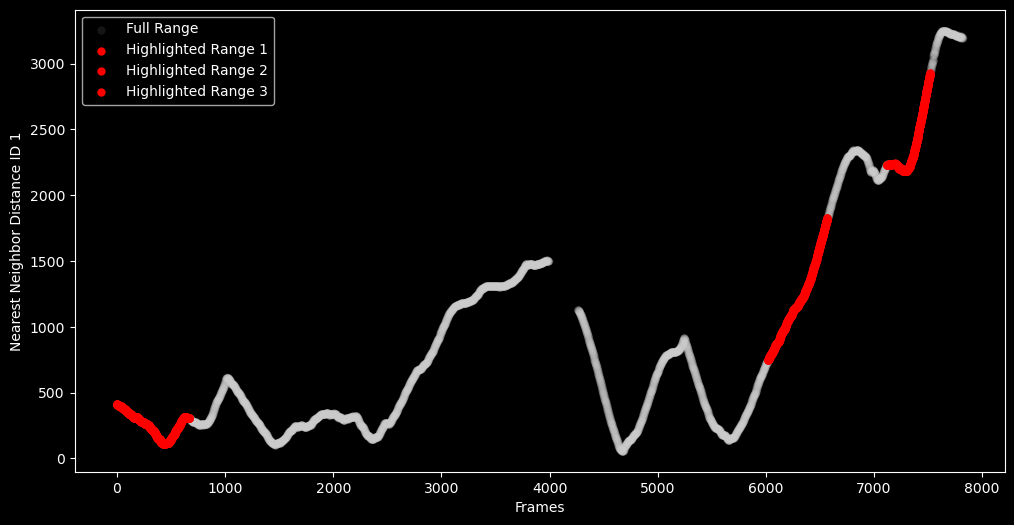

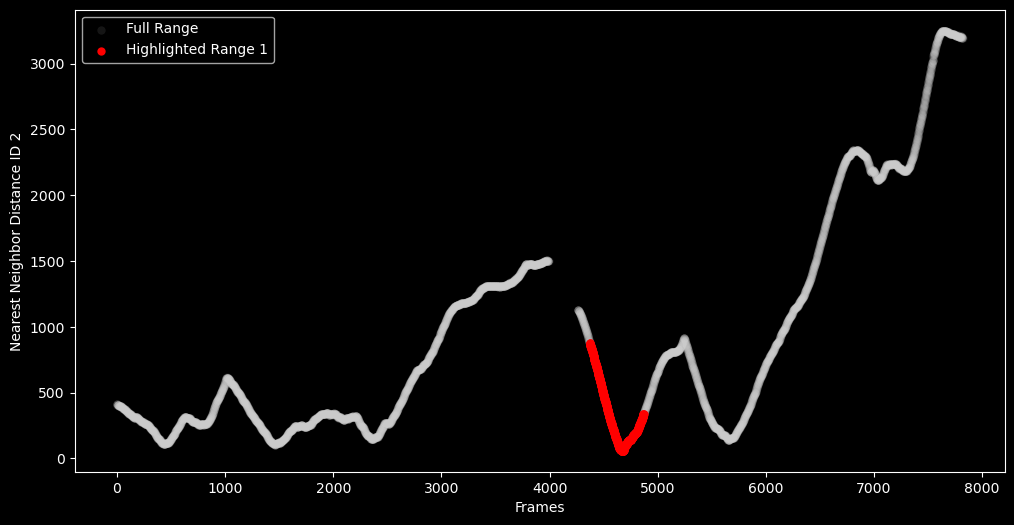

In [32]:
plt.figure(figsize=(12, 6))

# Plot the full range of nearest neighbor distances from 0 to 9104 (excluding highlighted parts)
full_range = range(0, 9104)
sns.scatterplot(x=full_range, y=nearest_neighbor_distances[0, 0:9104], color='lightgray', label='Full Range', alpha=0.1,linewidth=0)

# Highlight the specific frame ranges
sns.scatterplot(x=range(2370, 3320), y=nearest_neighbor_distances[0, 2370:3320], color='red', label='Highlighted Range 1',linewidth=0)
sns.scatterplot(x=range(5020, 5470), y=nearest_neighbor_distances[0, 5020:5470], color='red', label='Highlighted Range 2',linewidth=0)
sns.scatterplot(x=range(6620, 6970), y=nearest_neighbor_distances[0, 6620:6970], color='red', label='Highlighted Range 3',linewidth=0)

plt.xlabel('Frames')
plt.ylabel('Nearest Neighbor Distance ID0')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Plot the full range of nearest neighbor distances for ID 1 from 0 to 9104
full_range = range(0, 9104)
sns.scatterplot(x=full_range, y=nearest_neighbor_distances[1, 0:9104], color='lightgray', label='Full Range', alpha=0.1,linewidth=0)

# Highlight the new ranges for ID 1 (adjusted by subtracting 34530)
sns.scatterplot(x=range(0, 670), y=nearest_neighbor_distances[1, 0:670], color='red', label='Highlighted Range 1',linewidth=0)
sns.scatterplot(x=range(6020, 6570), y=nearest_neighbor_distances[1, 6020:6570], color='red', label='Highlighted Range 2',linewidth=0)
sns.scatterplot(x=range(7120, 7520), y=nearest_neighbor_distances[1, 7120:7520], color='red', label='Highlighted Range 3',linewidth=0)

plt.xlabel('Frames')
plt.ylabel('Nearest Neighbor Distance ID 1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Plot the full range of nearest neighbor distances for ID 1 from 0 to 9104
full_range = range(0, 9104)
sns.scatterplot(x=full_range, y=nearest_neighbor_distances[1, 0:9104], color='lightgray', label='Full Range', alpha=0.1,linewidth=0)

# Highlight the new ranges for ID 1 (adjusted by subtracting 34530)
sns.scatterplot(x=range(4370, 4870), y=nearest_neighbor_distances[1, 4370:4870], color='red', label='Highlighted Range 1',linewidth=0)

plt.xlabel('Frames')
plt.ylabel('Nearest Neighbor Distance ID 2')
plt.legend()
plt.show()

In [64]:
sharks_df['Trial_num']= sharks_df['Trial'].astype('category').cat.codes

In [77]:
example_avg = sharks_df[['ID','carangids','SPEED#wcentroid','Trial_num']].groupby(['carangids','Trial_num','ID']).mean().reset_index()

In [78]:
example_avg

,carangids,Trial_num,ID,SPEED#wcentroid
0,0,0,0,111.512354
1,0,0,1,112.137661
2,0,0,2,100.924604
3,0,0,3,105.598539
4,0,1,0,115.571357
5,0,1,1,113.369018
6,0,1,2,112.189376
7,1,0,0,153.075871
8,1,0,1,123.130877
9,1,0,2,119.455714


<Axes: xlabel='carangids', ylabel='SPEED#wcentroid'>

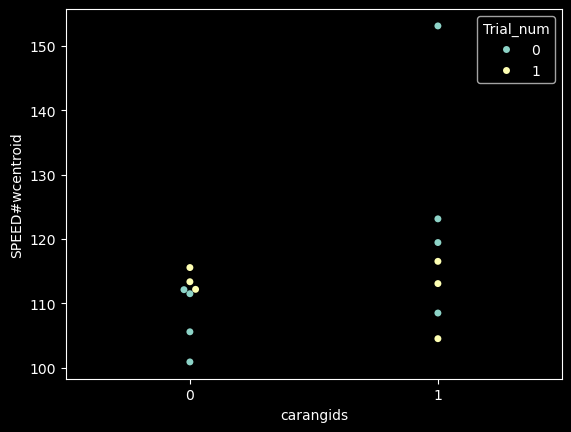

In [80]:
sns.swarmplot(x='carangids',y='SPEED#wcentroid',hue='Trial_num',data = example_avg)

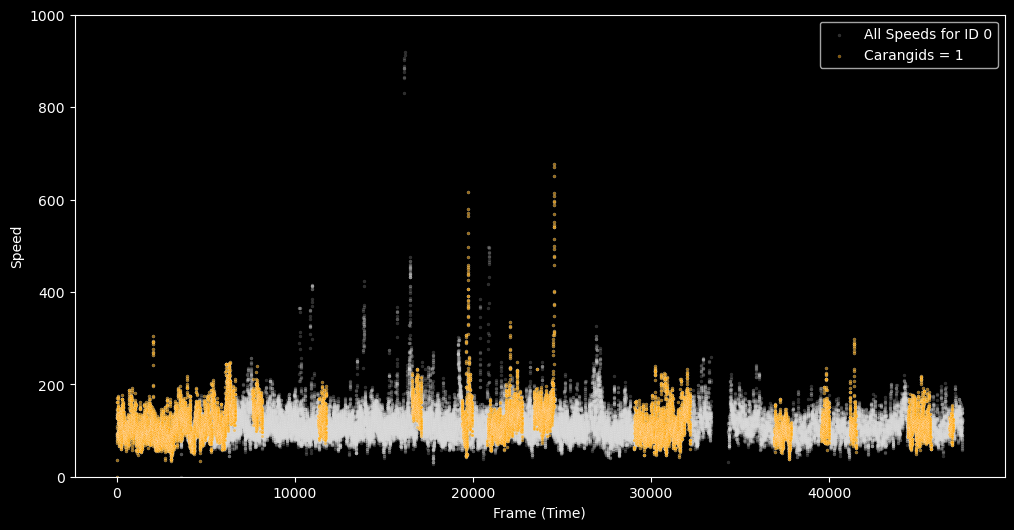

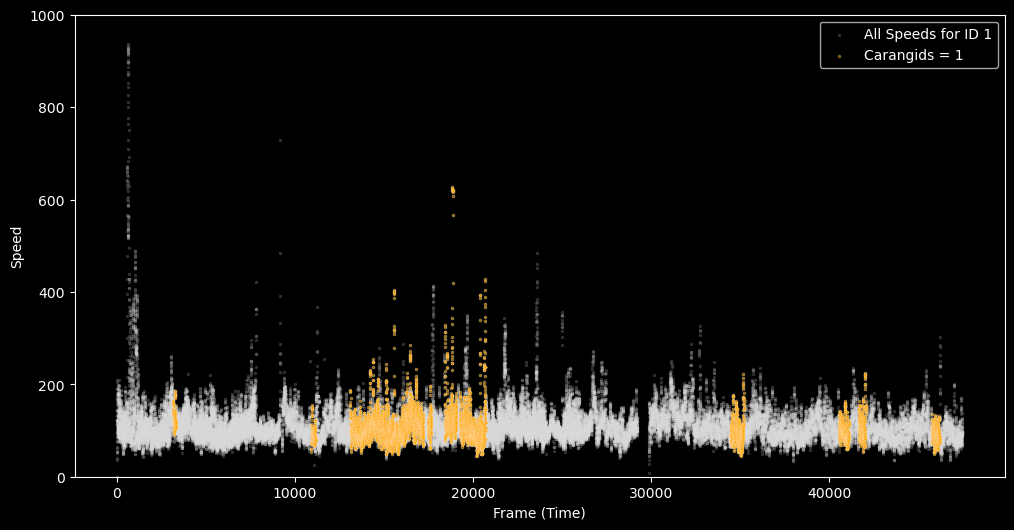

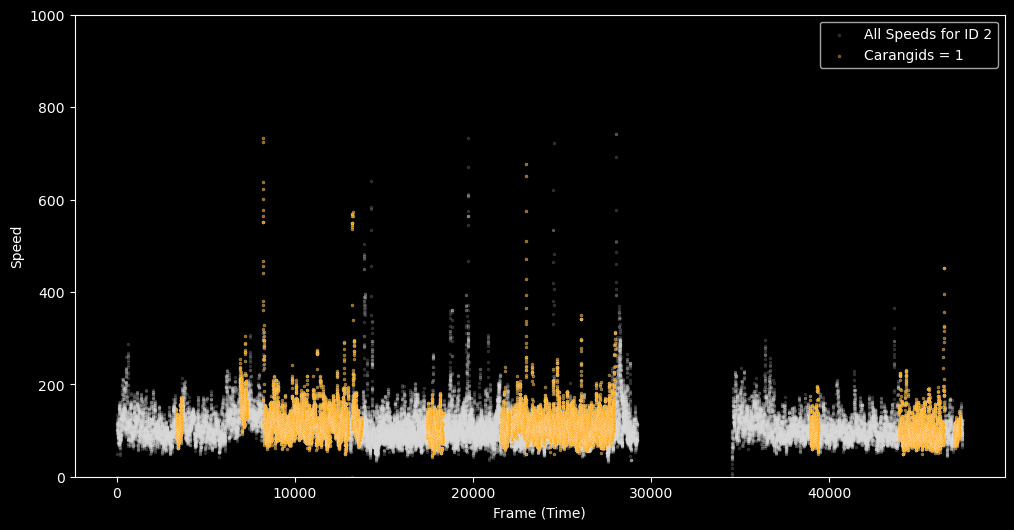

In [34]:
# Get unique IDs
unique_ids = subset['ID'].unique()

# Plot each ID separately
for shark_id in unique_ids:
    # Filter data for the current ID
    id_data = sharks_df[sharks_df['ID'] == shark_id]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot all points in light gray with scatterplot
    sns.scatterplot(x=id_data['frame'], y=id_data['SPEED#wcentroid'], color='lightgray', alpha=0.2, s=5, label=f'All Speeds for ID {shark_id}')

    # Highlight regions where Carangids = 1 in orange with scatterplot
    carangids_mask = id_data['carangids'] == 1
    sns.scatterplot(x=id_data['frame'][carangids_mask], y=id_data['SPEED#wcentroid'][carangids_mask], color='orange', s=5, alpha=0.5, label='Carangids = 1')
    
    # Set y-axis limit
    plt.ylim(0, 1000)
    
    # Plot styling
    plt.xlabel('Frame (Time)')
    plt.ylabel('Speed')
    plt.legend()
    plt.show()

In [35]:
# Group by 'ID' and 'carangids' and calculate mean speed
mean_speeds = sharks_df.groupby(['ID', 'carangids','Trial'])['SPEED#wcentroid'].mean().reset_index()

# Rename columns for clarity
mean_speeds = mean_speeds.rename(columns={'SPEED#wcentroid': 'mean_speed'})

# Split mean speeds into separate DataFrames for easy viewing if desired
mean_speeds_carangids_0 = mean_speeds[mean_speeds['carangids'] == 0]
mean_speeds_carangids_1 = mean_speeds[mean_speeds['carangids'] == 1]

# Display the result
print("Mean speeds for carangids = 0:")
print(mean_speeds_carangids_0)

print("\nMean speeds for carangids = 1:")
print(mean_speeds_carangids_1)


Mean speeds for carangids = 0:
    ID  carangids                                 Trial  mean_speed
0    0          0  sequence_20240303_071644282_DJI_0262  111.512354
1    0          0  sequence_20240305_164039273_DJI_0305  115.571357
4    1          0  sequence_20240303_071644282_DJI_0262  112.137661
5    1          0  sequence_20240305_164039273_DJI_0305  113.369018
8    2          0  sequence_20240303_071644282_DJI_0262  100.924604
9    2          0  sequence_20240305_164039273_DJI_0305  112.189376
12   3          0  sequence_20240303_071644282_DJI_0262  105.598539

Mean speeds for carangids = 1:
    ID  carangids                                 Trial  mean_speed
2    0          1  sequence_20240303_071644282_DJI_0262  153.075871
3    0          1  sequence_20240305_164039273_DJI_0305  116.536547
6    1          1  sequence_20240303_071644282_DJI_0262  123.130877
7    1          1  sequence_20240305_164039273_DJI_0305  104.533932
10   2          1  sequence_20240303_071644282_DJI_02

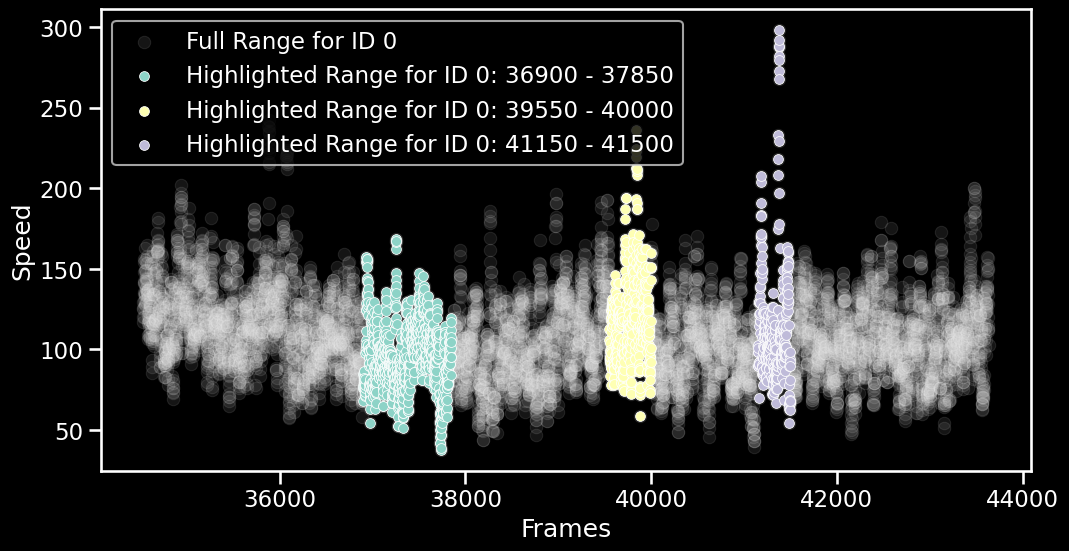

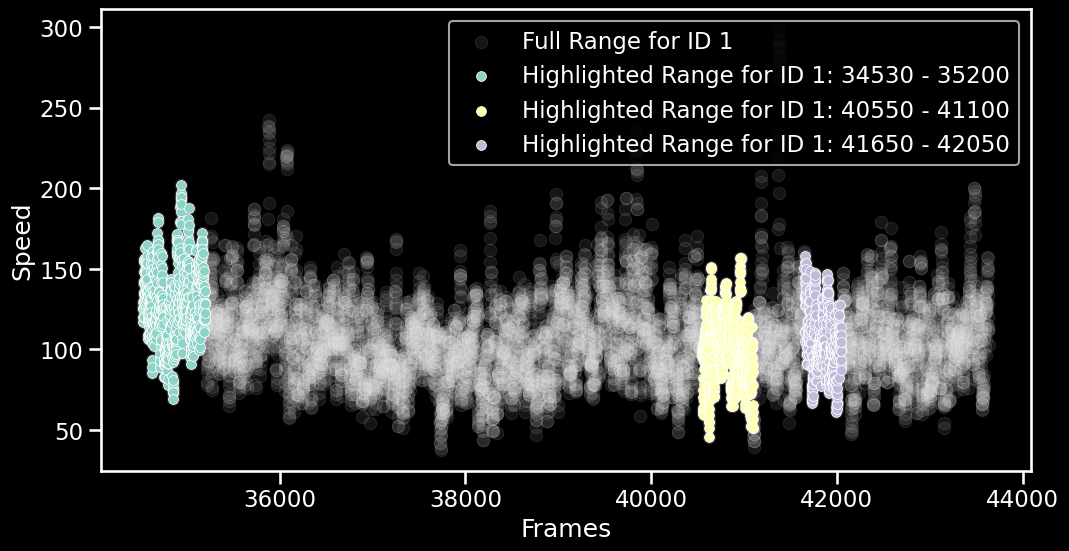

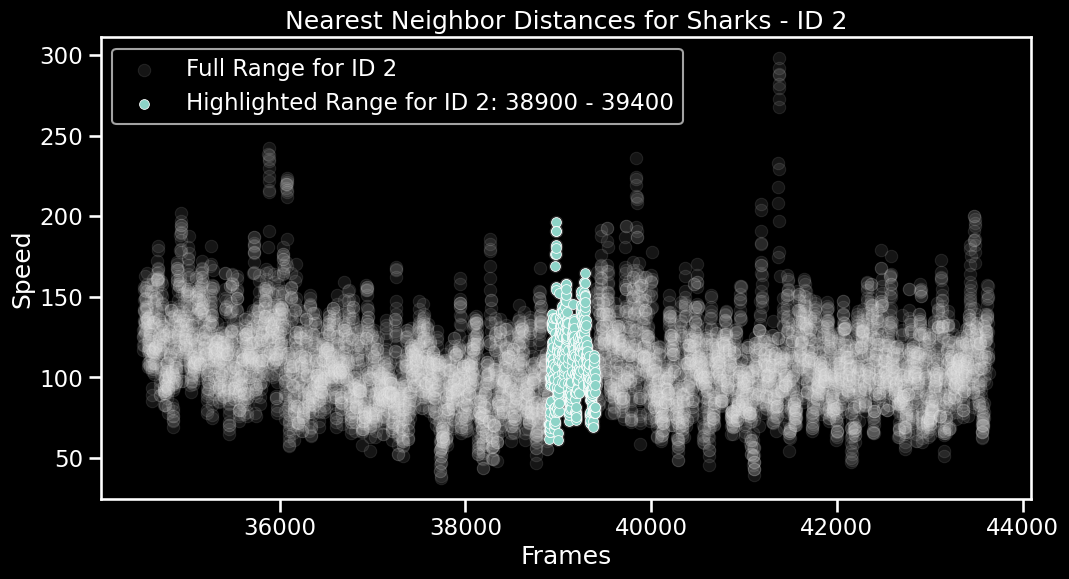

In [129]:

# Set up the figure for ID 0
plt.figure(figsize=(12, 6))

# Extract ranges for ID 0
ranges_id_0 = id_ranges_df[id_ranges_df['ID'] == 0]

# Plot full range for ID 0
fullrange_id_0 = range(34530, 43633)
sns.scatterplot(x=fullrange_id_0, 
                y=sharks_df['SPEED#wcentroid'].iloc[34530:43633], 
                color='lightgray', label='Full Range for ID 0', alpha=0.1)

# Plot each highlighted range for ID 0
for index, row in ranges_id_0.iterrows():
    start = row['range_start']
    end = row['range_end']
    sns.scatterplot(x=range(start, end), 
                    y=sharks_df['SPEED#wcentroid'].iloc[start:end], 
                    label=f'Highlighted Range for ID 0: {start} - {end}', 
                    s=50)

plt.xlabel('Frames')
plt.ylabel('Speed')
plt.legend()
plt.show()

# Set up the figure for ID 1
plt.figure(figsize=(12, 6))

# Extract ranges for ID 1
ranges_id_1 = id_ranges_df[id_ranges_df['ID'] == 1]

# Plot full range for ID 1
fullrange_id_1 = range(34530, 43633)
sns.scatterplot(x=fullrange_id_1, 
                y=sharks_df['SPEED#wcentroid'].iloc[34530:43633], 
                color='lightgray', label='Full Range for ID 1', alpha=0.1)

# Plot each highlighted range for ID 1
for index, row in ranges_id_1.iterrows():
    start = row['range_start']
    end = row['range_end']
    sns.scatterplot(x=range(start, end), 
                    y=sharks_df['SPEED#wcentroid'].iloc[start:end], 
                    label=f'Highlighted Range for ID 1: {start} - {end}', 
                    s=50)

plt.xlabel('Frames')
plt.ylabel('Speed')
plt.legend()
plt.show()

# Set up the figure for ID 2
plt.figure(figsize=(12, 6))

# Extract ranges for ID 2
ranges_id_2 = id_ranges_df[id_ranges_df['ID'] == 2]

# Plot full range for ID 2
sns.scatterplot(x=fullrange_id_0, 
                y=sharks_df['SPEED#wcentroid'].iloc[34530:43633], 
                color='lightgray', label='Full Range for ID 2', alpha=0.1)

# Plot each highlighted range for ID 2
for index, row in ranges_id_2.iterrows():
    start = row['range_start']
    end = row['range_end']
    sns.scatterplot(x=range(start, end), 
                    y=sharks_df['SPEED#wcentroid'].iloc[start:end], 
                    label=f'Highlighted Range for ID 2: {start} - {end}', 
                    s=50)

plt.xlabel('Frames')
plt.ylabel('Speed')
plt.title('Nearest Neighbor Distances for Sharks - ID 2')
plt.legend()
plt.show()

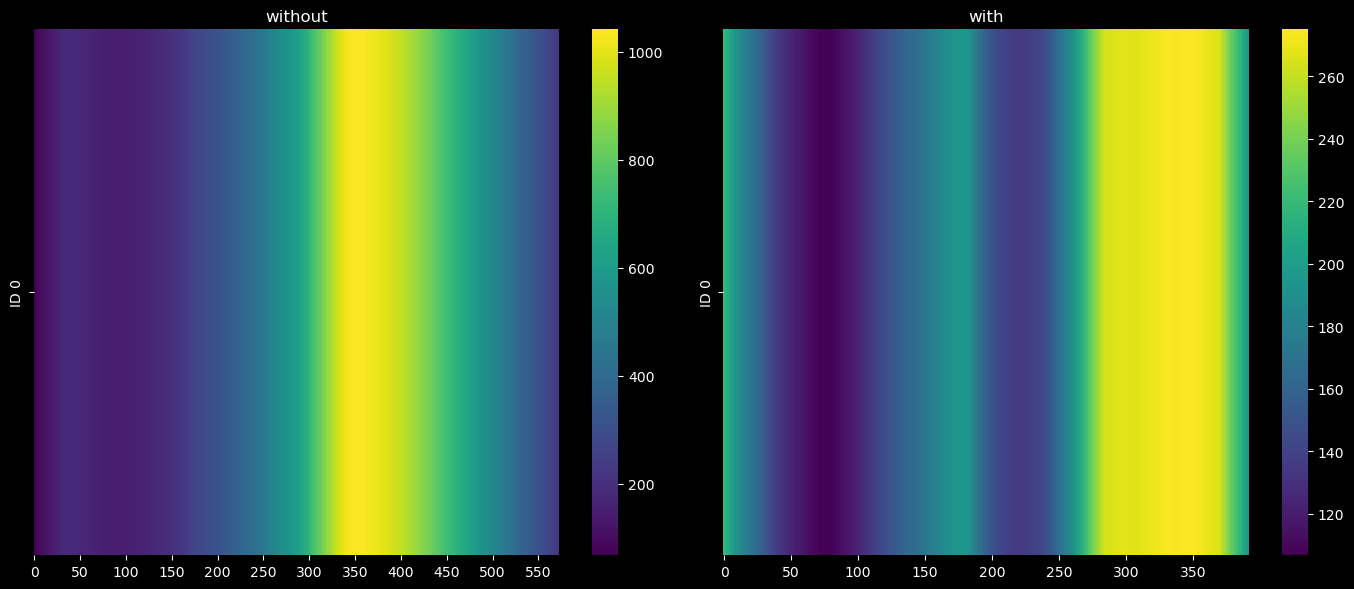

In [42]:
plt.figure(figsize=(14, 6))  # Create a single figure for both subplots

# First heatmap (frames 574-966)
plt.subplot(1, 2, 2)  # Create the first subplot (1 row, 2 columns, 1st plot)
sns.heatmap(nearest_neighbor_distances[0:1, 574:966], cmap='viridis', cbar=True, 
            xticklabels=50, yticklabels=['ID 0'])
plt.title('with')

# Second heatmap (frames 0-573)
plt.subplot(1, 2, 1)  # Create the second subplot (1 row, 2 columns, 2nd plot)
sns.heatmap(nearest_neighbor_distances[0:1, 0:573], cmap='viridis', cbar=True, 
            xticklabels=50, yticklabels=['ID 0'])
plt.title('without')

plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()


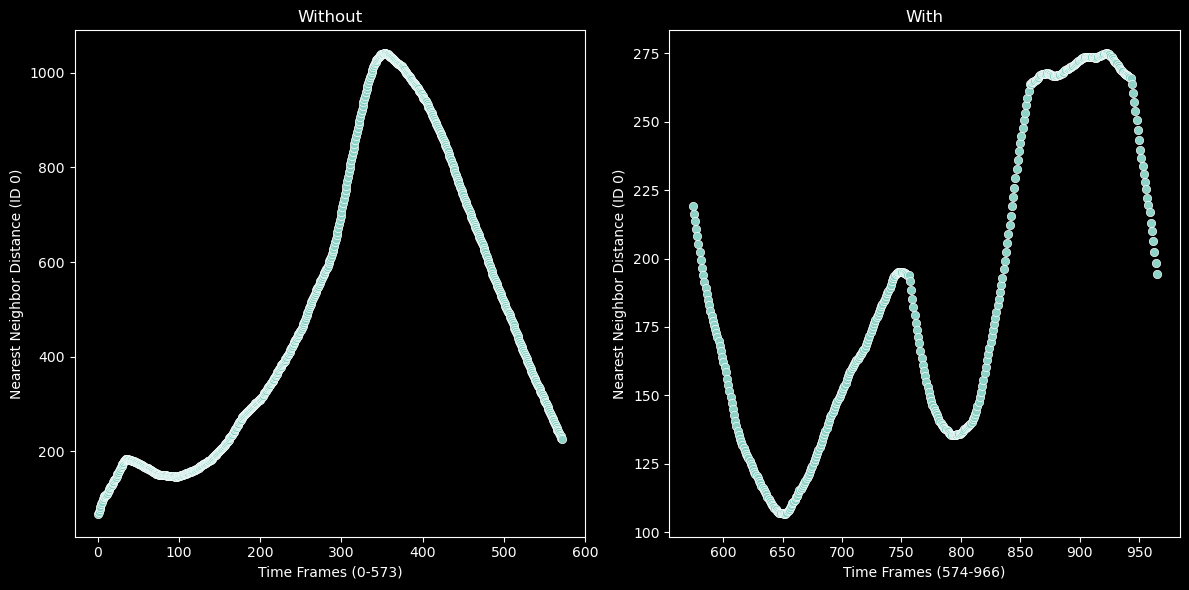

In [43]:
# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# First scatter plot (frames 574-966)
plt.subplot(1, 2, 1)  # First subplot (left side)
sns.scatterplot(x=range(574, 966), y=nearest_neighbor_distances[0, 574:966])
plt.title('With')


# Second scatter plot (frames 0-573)
plt.subplot(1, 2, 2)  # Second subplot (right side)
sns.scatterplot(x=range(0, 573), y=nearest_neighbor_distances[0, 0:573])
plt.title('Without')


# Show the plots
plt.tight_layout()
plt.show()

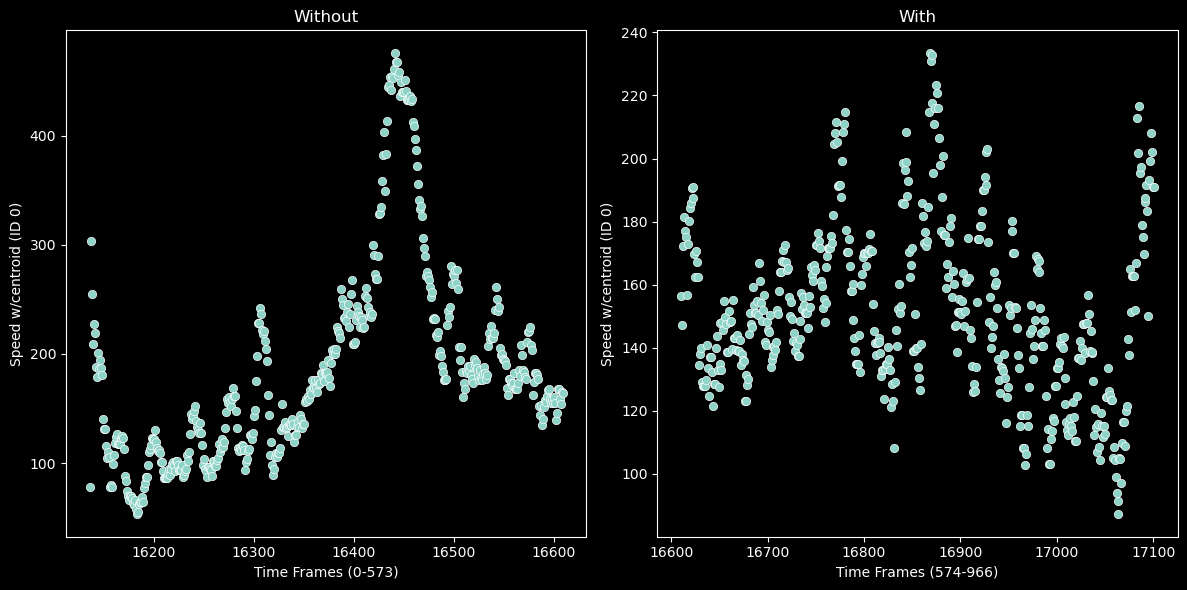

In [44]:
# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# First scatter plot (frames 574-966)
plt.subplot(1, 2, 2)  # First subplot (left side)
sns.scatterplot(x=range(16610,17102), y=sharks_df['SPEED#wcentroid'].iloc[16610:17102])
plt.title('With')
plt.xlabel('Time Frames (574-966)')
plt.ylabel('Speed w/centroid (ID 0)')

# Second scatter plot (frames 0-573)
plt.subplot(1, 2, 1)  # Second subplot (right side)
sns.scatterplot(x=range(16136,16610), y=sharks_df['SPEED#wcentroid'].iloc[16136:16610])
plt.title('Without')
plt.xlabel('Time Frames (0-573)')
plt.ylabel('Speed w/centroid (ID 0)')

# Show the plots
plt.tight_layout()
plt.show()

In [45]:
def calculate_acceleration(speeds, fps):
    """
    Calculates the acceleration between consecutive speed values.

    :param speeds: List or array of speed values (in meters per second, for example).
    :param fps: Frames per second (FPS) of the data.
    :return: Array of accelerations (one less than the number of speed values).
    """
    time_interval = 1 / fps  # Calculate the time interval between frames
    speeds = np.array(speeds)  # Convert speeds to a numpy array for easy math
    accelerations = (speeds[1:] - speeds[:-1]) / time_interval
    return accelerations

fps = 50  # 50 frames per second

# Access the 'SPEED#wcentroid' column from the DataFrame
speeds = sharks_df['SPEED#wcentroid'].values  # Extract column as numpy array

# Calculate acceleration for the interval 
speeds_interval_1 = speeds[16136:16610]  
accelerations_interval_1 = calculate_acceleration(speeds_interval_1, fps)


# Calculate acceleration for the interval 
speeds_interval_2 = speeds[16610:17102]  
accelerations_interval_2 = calculate_acceleration(speeds_interval_2, fps)


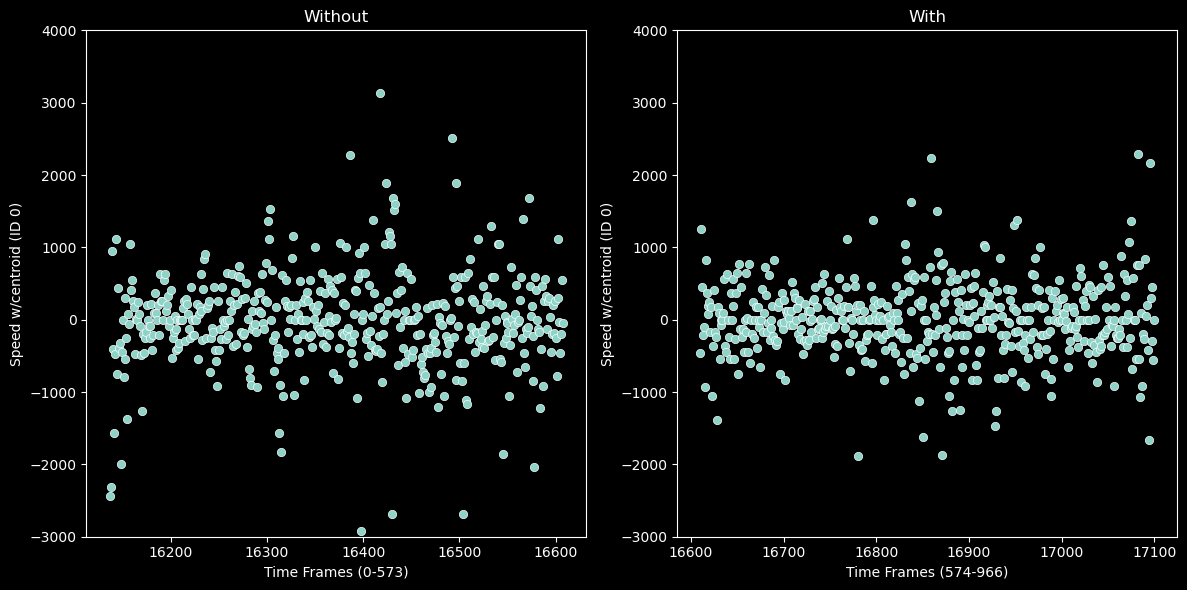

In [46]:
# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# First scatter plot (frames 574-966)
plt.subplot(1, 2, 2)  # First subplot (right side)
sns.scatterplot(x=range(16610,17101), y=accelerations_interval_2)
plt.title('With')
plt.xlabel('Time Frames (574-966)')
plt.ylabel('Speed w/centroid (ID 0)')
plt.ylim(top=4000, bottom=-3000)  # Limit the y-axis to stop around 4000

# Second scatter plot (frames 0-573)
plt.subplot(1, 2, 1)  # Second subplot (left side)
sns.scatterplot(x=range(16136,16609), y=accelerations_interval_1)
plt.title('Without')
plt.xlabel('Time Frames (0-573)')
plt.ylabel('Speed w/centroid (ID 0)')
plt.ylim(top=4000, bottom=-3000)  # Limit the y-axis to stop around 4000

# Show the plots
plt.tight_layout()
plt.show()

### Analysis in egocentric coordinates
This analysis includes centering and rotating the shark coordinates

,SPEED#wcentroid,ANGLE,frame,time,headx,heady,lxfinx,lxfiny,btipx,btipy,...,pedunclex,peduncley,finx,finy,ttipx,ttipy,X,Y,segment,Trial
ID,,,,,,,,,,,,,,,,,,,,,
0,28649,28649,29221,29221,28649,28649,28649,28649,28649,28649,...,28647,28647,28643,28643,28642,28642,28649,28649,29221,29221
1,29198,29198,29221,29221,29198,29198,29198,29198,29198,29198,...,29198,29198,29198,29198,29198,29198,29198,29198,29221,29221
2,15940,15927,28634,28634,15927,15927,15927,15927,15927,15927,...,15927,15927,15927,15927,15927,15927,15927,15927,28634,28634
3,25650,25645,28595,28595,25645,25645,25632,25632,25632,25632,...,25632,25632,25632,25632,25632,25632,25645,25645,28595,28595
4,68,68,11455,11455,15,15,15,15,15,15,...,68,68,68,68,68,68,68,68,11455,11455
